In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy.fftpack import dct, idct
from scipy.optimize import minimize
sys.path.append(os.path.join('..'))
from physics215ProjectCode import cosamp_fn as cf
from physics215ProjectCode import constructionSynthetic as cS

## Testing (Single Wave, at sampling frequency below Nyquist)

In [2]:
n = 4096 # points in high resolution signal
f_orig = 600
t_final = 1
t_start = 0
p = 120
p_uni = 900


x, PSD_orig, t = cS.constructSyntheticSignal(n, f_orig, t_final)
x_recon, PSD_recon, perm_rand = cf.reconstructSignal_dct(x, p)
x_recon_uni, PSD_recon_uni, perm_uni = cf.reconstructSignal_UniformSpacedSamples_dct(x, p_uni)

### Plotting (Single Wave Reconstruction)

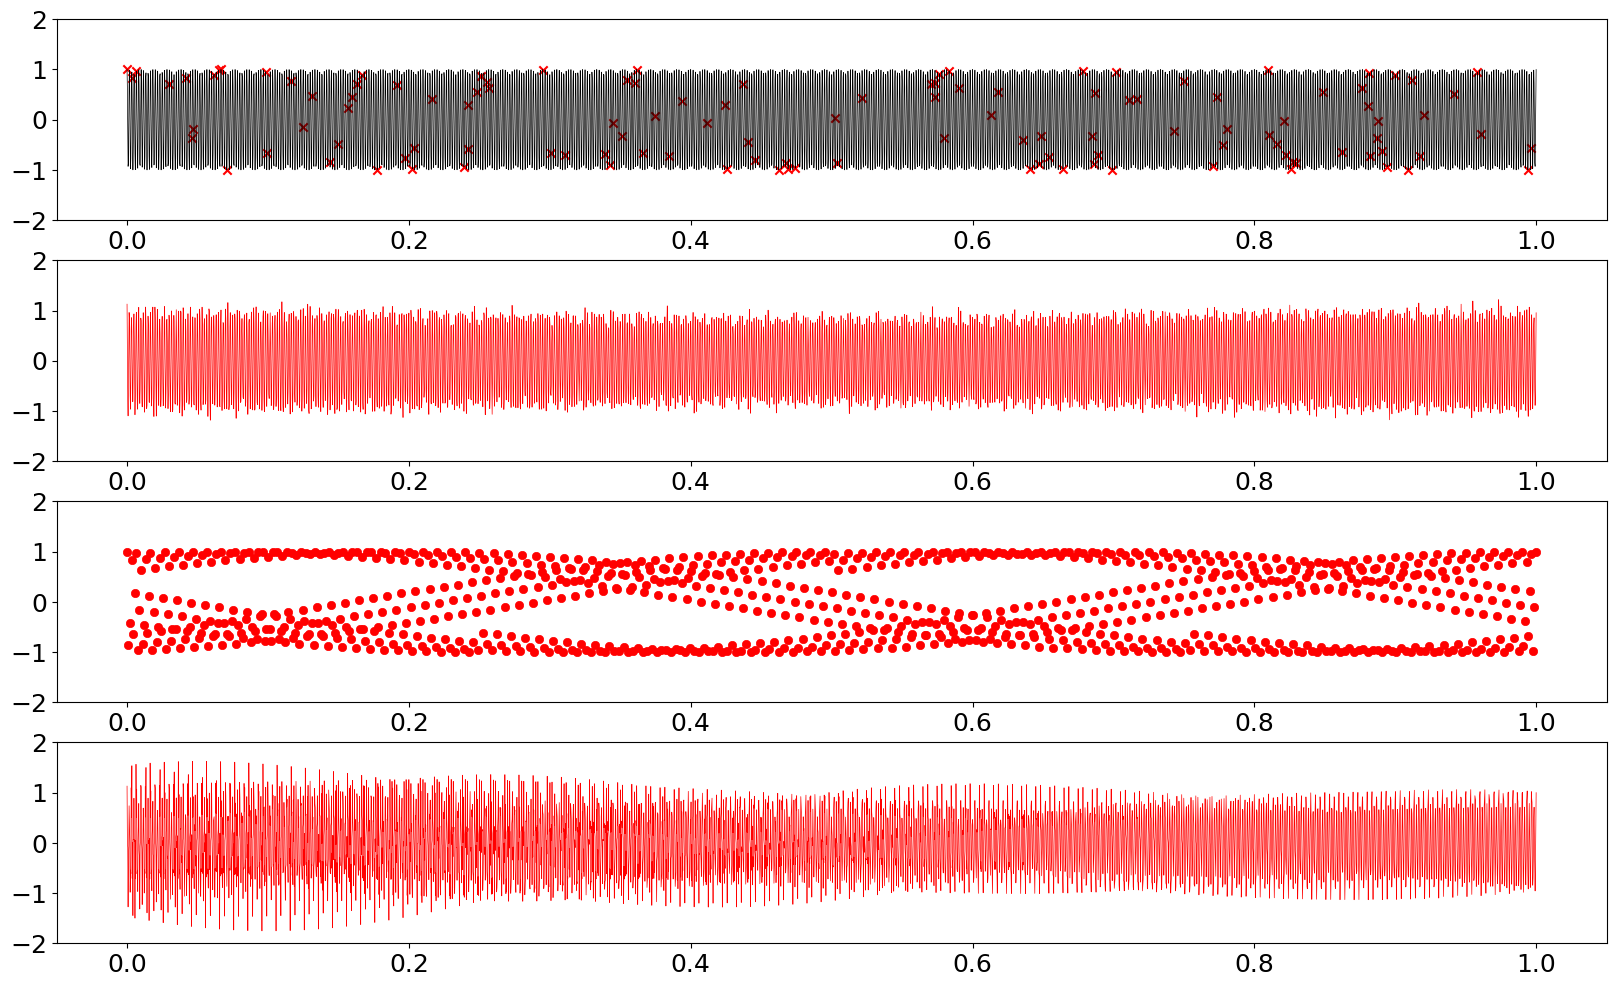

In [3]:
plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams.update({'font.size': 18})

fig,axs = plt.subplots(4,1)
axs = axs.reshape(-1)
ylim = (-2,2)
ylim_uni = (ylim[0]*3000, ylim[1]*3000)

axs[0].plot(t,x,color='k',linewidth=0.5)
axs[0].scatter(t[perm_rand],x[perm_rand],color='r',marker='x', label='sampled')
#axs[0].set_xlim(time_window[0],time_window[1])
axs[0].set_ylim(ylim)

axs[1].plot(t,x_recon,color='r',linewidth=0.5)
#axs[1].set_xlim(time_window[0],time_window[1])
axs[1].set_ylim(ylim)

axs[2].scatter(t[perm_uni],x[perm_uni],color='r',linewidth=0.5)
#axs[2].set_xlim(time_window[0],time_window[1])
axs[2].set_ylim(ylim)

axs[3].plot(t,x_recon_uni,color='r',linewidth=0.5)
#axs[3].set_xlim(time_window[0],time_window[1])
axs[3].set_ylim(ylim)

plt.show()

### Plotting (PSD of original and reconstructed wave)

/home/jovyan/my-conda-envs/V2Phys215Project/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jovyan/my-conda-envs/V2Phys215Project/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


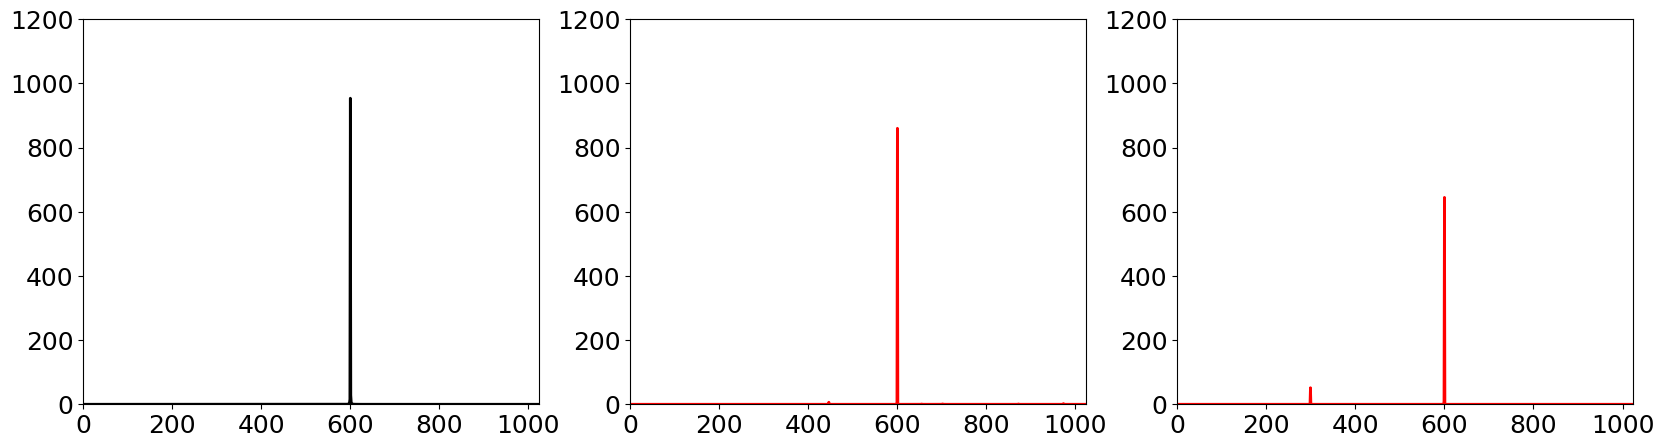

In [4]:
plt.rcParams['figure.figsize'] = [20,5]
plt.rcParams.update({'font.size': 18})

freq = np.arange(n)
L = int(np.floor(n/2))

fig,axs = plt.subplots(1,3)
axs = axs.reshape(-1)
ylim = (0,1200)
xlim = (0, 1024)

axs[0].plot(freq[:L],PSD_orig[:L],color='k',linewidth=2)
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)

axs[1].plot(freq[:L],PSD_recon[:L],color='r',linewidth=2)
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)

axs[2].plot(freq[:L],PSD_recon_uni[:L],color='r',linewidth=2)
axs[2].set_xlim(xlim)
axs[2].set_ylim(ylim)

plt.show()

## Comparing the PSDs of two methods using the RMSE 

We normalize the RMSE such that the distance between the spectra is 0 when it is equivalent to that at the original sampling frequency. It is a value 1 when the RMSE is equivalent to that when the sampling frequency is 1.5 times the signal's highest freuqnecy with uniform spacing $PSD_{1.5f_{orig}, uni}$- at this frequency with uniform spacing, we notice significant aliasing. 

$$ RMSE = \frac{\sqrt{(PSD_x - PSD_{4096})^2}}{\sqrt{(PSD_{1.5f_{orig}, uni} - PSD_{4096})^2}}$$

In [5]:
from physics215ProjectCode import comparison

In [6]:
n = 4096 # points in high resolution signal
f_orig = 600
t_final = 1
t_start = 0
p = 30
p_uni = 900

x, PSD_orig, t = cS.constructSyntheticSignal(n, f_orig, t_final)
x_recon_uni, PSD_recon_uni, perm_uni = cf.reconstructSignal_UniformSpacedSamples_dct(x, p_uni)


p_s = np.array([1200, 900, 600, 300, 150, 120, 100, 75, 60, 50, 40, 37, 35, 33, 30])
num_trials = 30
f_overp = f_orig/p_s 

rmse_norms = []

for p in p_s:
    rmse_norm = 0
    for i in range(num_trials):
        x_recon, PSD_recon, perm_rand = cf.reconstructSignal_dct(x, p)
        rmse_norm += comparison.rmse(PSD_orig, PSD_recon).real/comparison.rmse(PSD_orig, PSD_recon_uni).real
    rmse_norms.append(rmse_norm/num_trials)

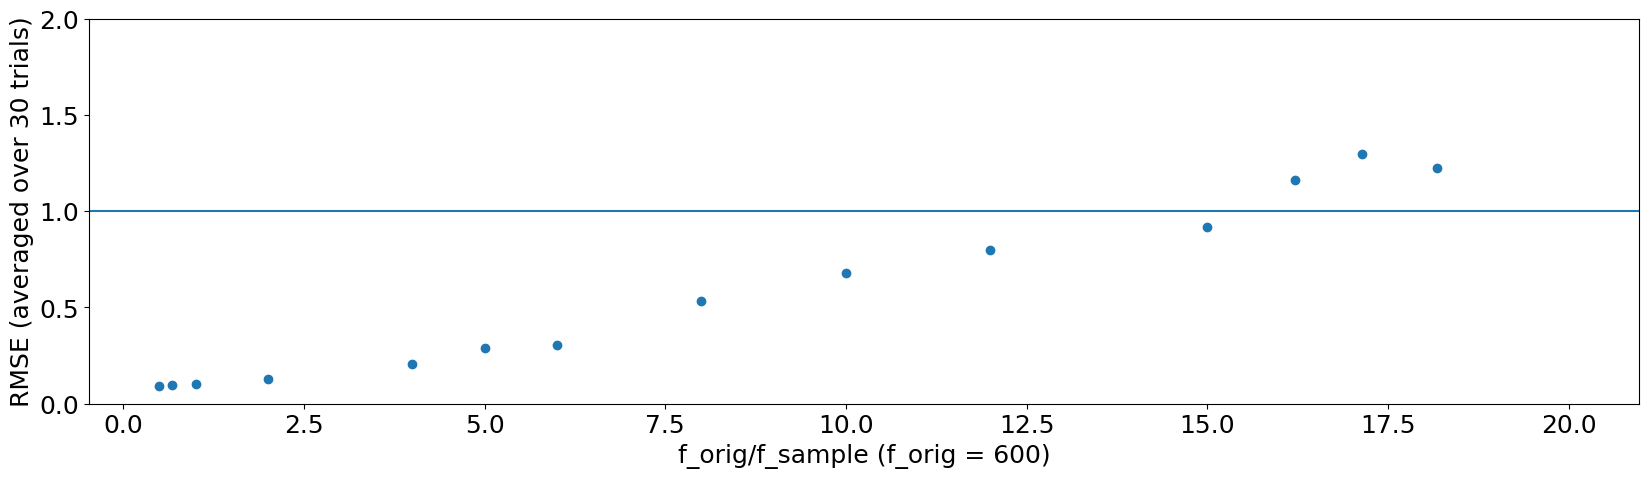

In [7]:
plt.scatter(f_overp, rmse_norms)
plt.ylim((0,2))
plt.xlabel(f"f_orig/f_sample (f_orig = {f_orig})")
plt.ylabel("RMSE (averaged over 30 trials)")
plt.axhline(1)
plt.show()

## Comparing the signals Directly using RMSE

We normalize the RMSE such that the distance between the spectra is 0 when it is equivalent to that at the original sampling frequency. It is a value 1 when the RMSE is equivalent to that when the sampling frequency is 1.5 times the signal's highest freuqnecy with uniform spacing $PSD_{1.5f_{orig}, uni}$- at this frequency with uniform spacing, we notice significant aliasing. 

$$ RMSE = \frac{\sqrt{(x_{recon}- x_{orig,4096})^2}}{\sqrt{(x_{uni, 1.5f_{orig}} - x_{orig, 4096})^2}}$$

In [8]:
n = 4096 # points in high resolution signal
f_orig = 600
t_final = 1
t_start = 0
p = 30
p_uni = 900

x, PSD_orig, t = cS.constructSyntheticSignal(n, f_orig, t_final)
x_recon_uni, PSD_recon_uni, perm_uni = cf.reconstructSignal_UniformSpacedSamples_dct(x, p_uni)


p_s = np.array([1200, 900, 600, 300, 150, 120, 100, 75, 60, 50, 40, 37, 35, 33, 30])
num_trials = 30
f_overp = f_orig/p_s 

rmse_norms = []

for p in p_s:
    rmse_norm = 0
    for i in range(num_trials):
        x_recon, PSD_recon, perm_rand = cf.reconstructSignal_dct(x, p)
        rmse_norm += comparison.rmse(x, x_recon).real/comparison.rmse(x, x_recon_uni).real
    rmse_norms.append(rmse_norm/num_trials)

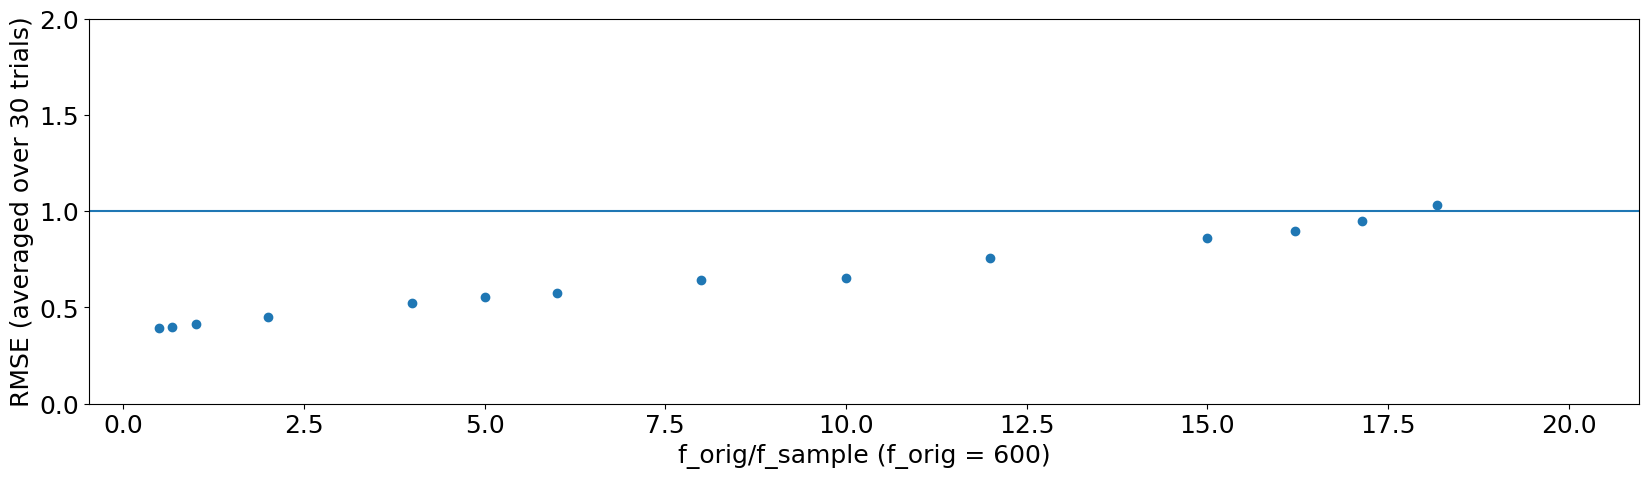

In [9]:
plt.scatter(f_overp, rmse_norms)
plt.ylim((0,2))
plt.xlabel(f"f_orig/f_sample (f_orig = {f_orig})")
plt.ylabel("RMSE (averaged over 30 trials)")
plt.axhline(1)
plt.show()

## Testing (Single Wave, at sampling frequency ABOVE Nyquist)

In [10]:
n = 4096 # points in high resolution signal
f_orig = 600
t_final = 1
t_start = 0
p = 1500 #Must be above the Nyquist sampling Frequency of f_orig*2


x, PSD_orig, t = cS.constructSyntheticSignal(n, f_orig, t_final)
x_recon, PSD_recon, perm_rand = cf.reconstructSignal_dct(x, p)
x_recon_uni, PSD_recon_uni, perm_uni = cf.reconstructSignal_UniformSpacedSamples_dct(x, p)

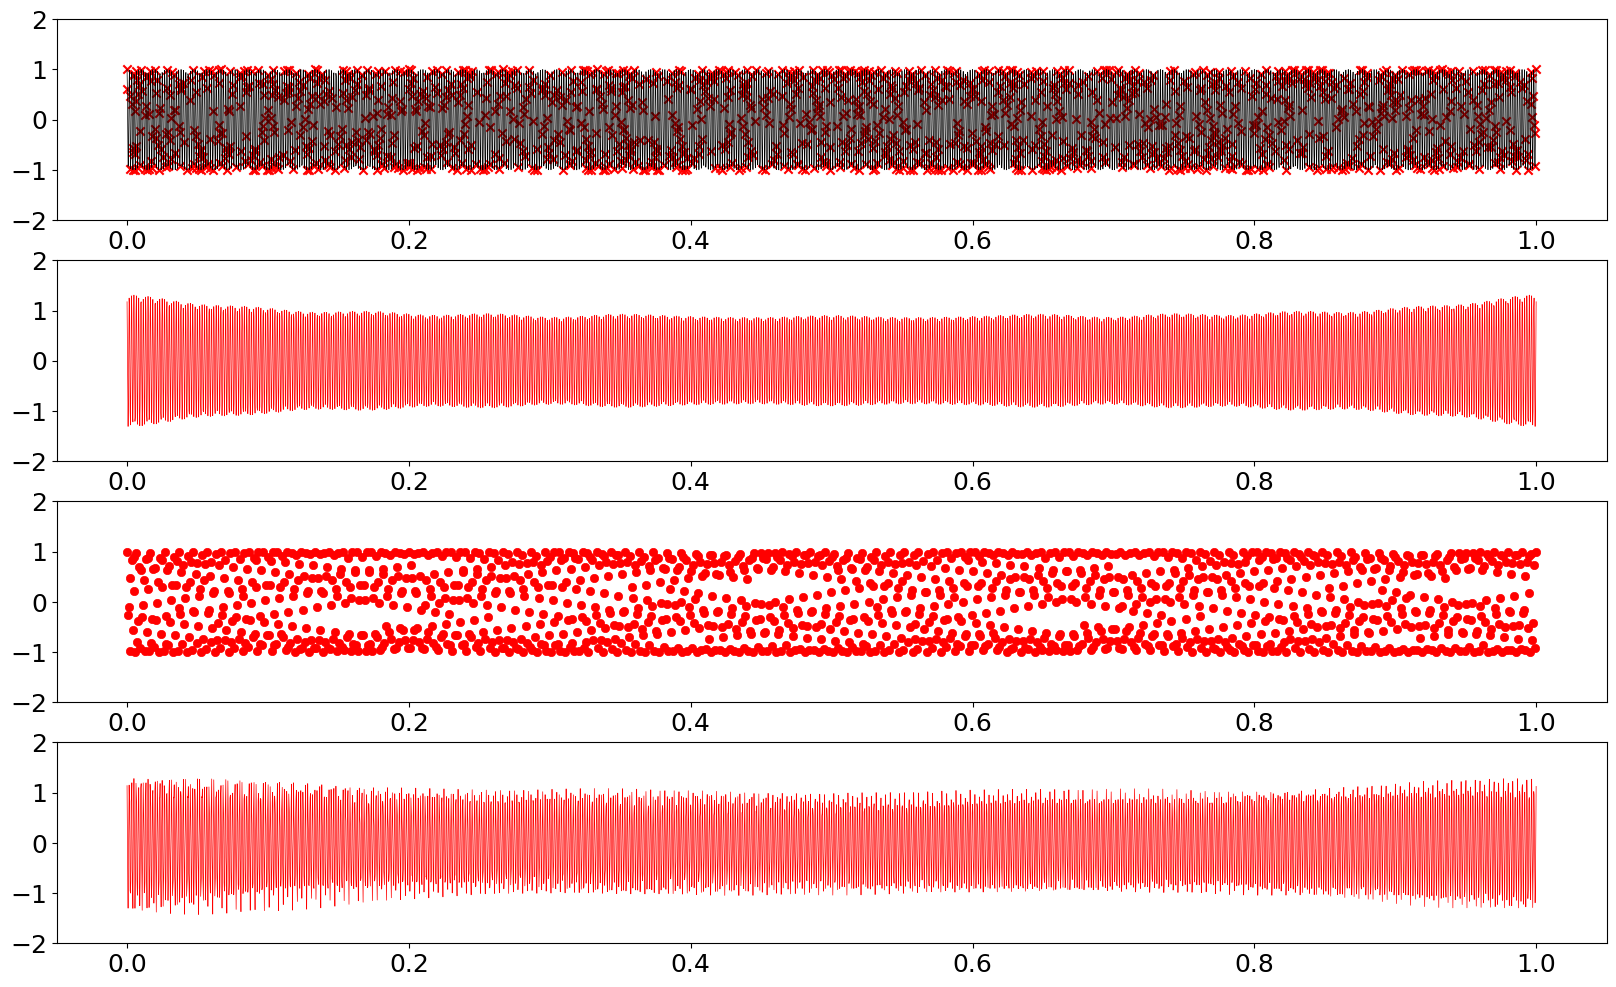

In [11]:
plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams.update({'font.size': 18})

fig,axs = plt.subplots(4,1)
axs = axs.reshape(-1)
ylim = (-2,2)
ylim_uni = (ylim[0]*3000, ylim[1]*3000)

axs[0].plot(t,x,color='k',linewidth=0.5)
axs[0].scatter(t[perm_rand],x[perm_rand],color='r',marker='x', label='sampled')
#axs[0].set_xlim(time_window[0],time_window[1])
axs[0].set_ylim(ylim)

axs[1].plot(t,x_recon,color='r',linewidth=0.5)
#axs[1].set_xlim(time_window[0],time_window[1])
axs[1].set_ylim(ylim)

axs[2].scatter(t[perm_uni],x[perm_uni],color='r',linewidth=0.5)
#axs[2].set_xlim(time_window[0],time_window[1])
axs[2].set_ylim(ylim)

axs[3].plot(t,x_recon_uni,color='r',linewidth=0.5)
#axs[3].set_xlim(time_window[0],time_window[1])
axs[3].set_ylim(ylim)

plt.show()

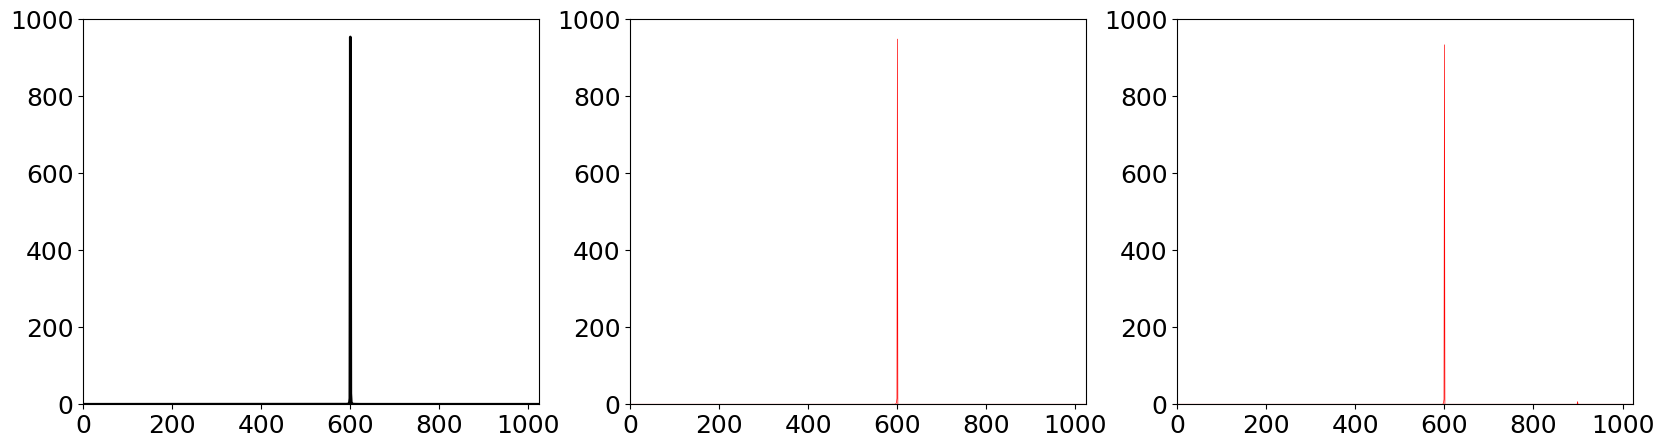

In [12]:
plt.rcParams['figure.figsize'] = [20,5]
plt.rcParams.update({'font.size': 18})

freq = np.arange(n)
L = int(np.floor(n/2))

fig,axs = plt.subplots(1,3)
axs = axs.reshape(-1)
ylim = (0,1000)
xlim = (0, 1024)

axs[0].plot(freq[:L],PSD_orig[:L],color='k',linewidth=2)
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)

axs[1].plot(freq[:L],PSD_recon[:L],color='r',linewidth=0.5)
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)

axs[2].plot(freq[:L],PSD_recon_uni[:L],color='r',linewidth=0.5)
axs[2].set_xlim(xlim)
axs[2].set_ylim(ylim)

plt.show()